In [119]:
# librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from googletrans import Translator
from scipy.stats import median_absolute_deviation
from collections import Counter, OrderedDict

# Initial data analysis with the cleaned dataset

In [120]:
def clean_nan(df,var):
    '''Given a dataframe df and a column var, returns a copy of df where the items for
    which var is a nan have been removed'''
    return df[df[var].isna()==False].copy()

In [121]:
def remove_outliers(df,var,k=3):
    '''Uses the MAD criterion to remove outliers. The data must be free of nans.
    Values that are above or below K times the MAD are removed from the data,
    and a copy of the dataframe is returned'''
    mad=median_absolute_deviation(df[var])
    mean=np.mean(df[var])
    return df[np.logical_and(df[var].values<mean+k*mad,df[var].values>mean-k*mad)].copy()

In [122]:
# Load the clean dataset
df_of_clean=pd.read_pickle('Data/df_openfacts_small.pkl')

In [123]:
df_ns=df_of_clean[df_of_clean['nutrition_grade_fr'].isna()==False].copy()

## Handling the names of the products
We define the following functions in order to clean and split the names of the products. Also we define a method which creates for a given nutrition grade a dictionnary with the number of appearances of each word.

In [124]:
# Text handling utilities
from string import punctuation
import unidecode
stopwords_list = open('Data/stopwords_new.txt', 'r').readlines()
stopwords_list = [x.strip() for x in stopwords_list]
def stopword_remover(text):
    text_list = text.split()
    text_list = [x for x in text_list if x not in stopwords_list]
    return ' '.join(text_list)
def lowercase_all(text):
    return text.lower()
def remove_punct(text):
    return ''.join([ch for ch in text if ch not in punctuation])
def remove_numbers(foo):
    return [x for x in foo if not any(x1.isdigit() for x1 in x)]
def sanitize_text_row(text):
    tmp=unidecode.unidecode(str(text))
    return stopword_remover(remove_punct(lowercase_all(tmp)))

In [125]:
df_ns['product_name']=df_ns['product_name'].apply(sanitize_text_row)

In [126]:
def extract_words(df):
   #concatenate the names
    name_concat=[]
    for i in df['product_name'].values: 
        for j in i.split(): 
            name_concat.append(j)           
    name_concat=remove_numbers(name_concat)

    return OrderedDict(sorted(Counter(name_concat).items(),\
                                  key = lambda kv : kv[1], reverse=True))

In [127]:
all_words_dict=extract_words(df_ns)

In [8]:
#df_ns=pd.read_pickle('df_ns.pkl')

In [9]:
#df_ns.to_pickle('df_ns.pkl')

In [128]:
with open('translated_dict_all.pickle', 'rb') as handle:
    translated_dict_all = pickle.load(handle)

In [129]:
def insert_translation(text):
    trans_text=[]
    for word in text.split():
        try:
            trans_text.append(list(translated_dict_all[word])[0])
        except:
            trans_text.append(word)
    return ' '.join(trans_text) 

In [130]:
df_ns['product_name']=df_ns['product_name'].apply(insert_translation)

In [131]:
def extract_words_by_grade(df,nutritional_grade='a'):
    '''applies the text handling utilities to the subset of the dataframe corresponding to 
    nutritional_grade and returns a dictionnary containg the words and their count'''
    df_e=df[df['nutrition_grade_fr']==nutritional_grade].copy()
    prod_name=list(df_e['product_name'].values)
    name_concat=[]
    for i in prod_name: 
        for j in i.split(): 
            name_concat.append(j)
                
    name_concat=remove_numbers(name_concat)

    return OrderedDict(sorted(Counter(name_concat).items(),\
                                  key = lambda kv : kv[1], reverse=True))

## Creation of the Word Representation
We create a dictionnary using the previously defined functions for all the nutrition grades. We will also translate the words since the product names come in different languages (fr,de,es,en,etc). For now, we have a problem since the google API stops working after having translated 500 words which is problematic...

In [132]:
# create a dictionnary for all nutrition grades
grade_dict={}
for i in np.unique(df_ns['nutrition_grade_fr']):
    grade_dict[i]=extract_words_by_grade(df_ns,nutritional_grade=i)

In [21]:
df_ns

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,packaging,...,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
8,0000000000949,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1523440813,2018-04-11T10:00:13Z,1565268412,2019-08-08T12:46:52Z,salad carrots rapes,NaN,NaN,...,0.3,0.1,5.3,3.9,NaN,0.9,0.42,0.168,1.0,1.0
15,0000000001281,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1517830801,2018-02-05T11:40:01Z,1527070794,2018-05-23T10:19:54Z,pie nuts coco,NaN,"barquette,plastique",...,22.0,15.5,27.3,21.9,4.4,4.6,0.10,0.040,14.0,14.0
23,0000000001885,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1511180337,2017-11-20T12:18:57Z,1518126491,2018-02-08T21:48:11Z,compote perry,NaN,NaN,...,0.0,0.0,36.0,27.0,3.6,0.6,0.00,0.000,-2.0,-2.0
27,0000000002257,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1520506122,2018-03-08T10:48:42Z,1561463749,2019-06-25T11:55:49Z,salad macedoine legumes,NaN,NaN,...,12.7,1.0,3.9,1.0,NaN,1.9,0.27,0.108,1.0,1.0
48,0000000005005,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1521663684,2018-03-21T20:21:24Z,1545934272,2018-12-27T18:11:12Z,abondance,NaN,NaN,...,33.0,21.6,0.1,0.1,NaN,25.0,1.30,0.520,14.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010598,9999991042711,http://world-en.openfoodfacts.org/product/9999...,kiliweb,1548781141,2019-01-29T16:59:01Z,1557676679,2019-05-12T15:57:59Z,rice milk,NaN,NaN,...,6.1,4.3,21.0,14.0,NaN,2.9,0.08,0.032,7.0,7.0
1010600,9999991042742,http://world-en.openfoodfacts.org/product/9999...,kiliweb,1539597358,2018-10-15T09:55:58Z,1552297682,2019-03-11T09:48:02Z,mousse chocolat noir,85 g,NaN,...,27.0,17.0,19.0,18.0,NaN,6.0,0.19,0.076,17.0,17.0
1010601,9999991149090,http://world-en.openfoodfacts.org/product/9999...,kiliweb,1519146449,2018-02-20T17:07:29Z,1545339064,2018-12-20T20:51:04Z,rice parfume,NaN,NaN,...,0.5,0.0,80.0,0.0,NaN,7.0,0.00,0.000,0.0,0.0
1010605,9999999004360,http://world-en.openfoodfacts.org/product/9999...,kiliweb,1548086277,2019-01-21T15:57:57Z,1558357406,2019-05-20T13:03:26Z,minis donuts,NaN,NaN,...,20.2,6.0,30.9,10.4,NaN,7.4,1.10,0.440,15.0,15.0


### Visualization of the word representation
In this section, we provide barplots for each nutrition grade allowing us to vizualize which words are the most frequent per grade.

In [114]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [115]:
def plot_wordcloud(nutritionalgrade='a'):
    mask = np.array(Image.open('img/grade_'+nutritionalgrade+'.PNG'))
    wordcloud = WordCloud(relative_scaling=0.8,max_words=1000,
                mask=mask,background_color="rgba(255, 255, 255, 0)", mode="RGBA").generate_from_frequencies(dict(grade_dict[nutritionalgrade]))
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=(10,20))
    write_correct_letter(nutritionalgrade)
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [116]:
def write_correct_letter(nutritionalgrade):
    if nutritionalgrade=='a':
        plt.text(22, 148, 'A', fontsize=130,color='seagreen',alpha=0.7)
    if nutritionalgrade=='b':
        plt.text(115, 140, 'B', fontsize=130,color='lightgreen',alpha=0.7)
    if nutritionalgrade=='c':
        plt.text(208, 138, 'C', fontsize=130,color='gold',alpha=0.7)
    if nutritionalgrade=='d':
        plt.text(298, 143, 'D', fontsize=130,color='orange',alpha=0.7)
    if nutritionalgrade=='e':
        plt.text(405, 145, 'E', fontsize=130,color='orangered',alpha=0.7)

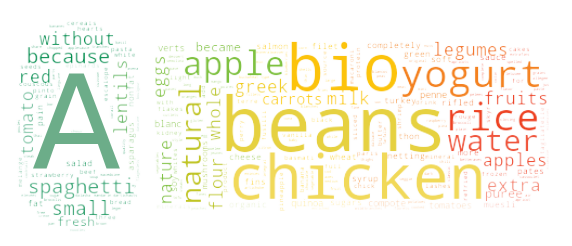

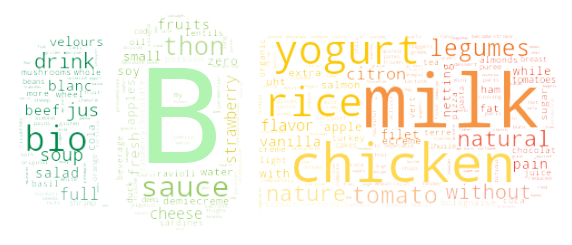

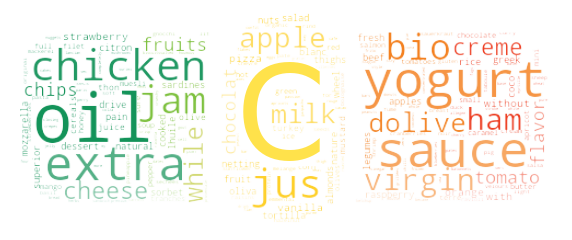

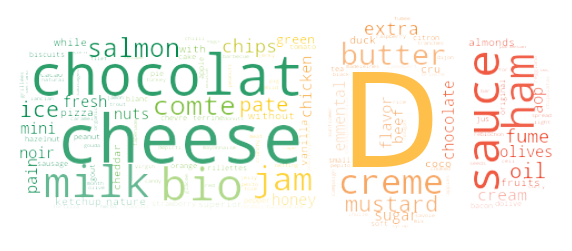

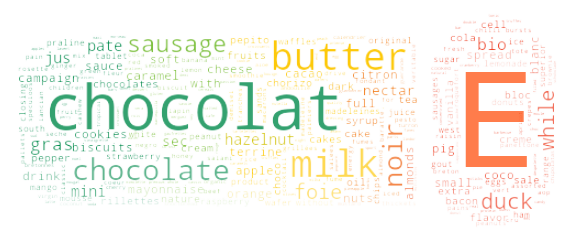

In [173]:
for i in ['a','b','c','d','e']:
    plot_wordcloud(nutritionalgrade=i)

In [ ]:
del df_of_clean  #delete a big variable to be able to load instacart

# Instacart dataset

In this section, we work with the [instacart](https://www.instacart.com/) dataset. In a first time, we make a initial analysis with this dataset alone, and then in a second time we link it with the openfoodfacts dataset.

**Dataset description**

`orders` (3.4m rows, 206k users):
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

`products` (50k rows):
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

`aisles` (134 rows):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

`deptartments` (21 rows):
* `department_id`: department identifier
* `department`: the name of the department

`order_products__SET` (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the four following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders)
* `"train"`: training data supplied to participants (~131k orders)
* `"test"`: test data reserved for machine learning competitions (~75k orders)

## Load the data and initial analysis

In [6]:
aisles_path='Data/instacart_2017_05_01/aisles.csv'
dep_path='Data/instacart_2017_05_01/departments.csv'
orders_path='Data/instacart_2017_05_01/orders.csv'
products_path='Data/instacart_2017_05_01/products.csv'
o_ppath='Data/instacart_2017_05_01/order_products__prior.csv'

In [7]:
aisles=pd.read_csv(aisles_path)
dep=pd.read_csv(dep_path)
orders=pd.read_csv(orders_path)
products=pd.read_csv(products_path)
oprior=pd.read_csv(o_ppath)

# We process the data in order to have all information about products, order id, nutrition grade in a single dataframe. Need to do it once to create the pickle file

In [16]:
products.product_id.is_unique # The key values of each dataset

True

In [17]:
orders.order_id.is_unique

True

In [18]:
products=products.set_index('product_id')

In [19]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [20]:
orders.shape

(3421083, 7)

In [21]:
# keep only orders were eval_set = prior (biggest subset) to then join with oprior
orders = orders[orders.eval_set=="prior"]

In [22]:
orders.shape

(3214874, 7)

In [23]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [24]:
print(oprior.shape)
oprior.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [58]:
orders_merged = pd.merge(oprior, orders, on='order_id')

In [59]:
orders_merged

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0
...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,25247,prior,24,2,6,21.0
32434485,3421083,11352,7,0,25247,prior,24,2,6,21.0
32434486,3421083,4600,8,0,25247,prior,24,2,6,21.0
32434487,3421083,24852,9,1,25247,prior,24,2,6,21.0


In [60]:
# test
orders[orders.order_id == 2]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3355525,2,202279,prior,3,5,9,8.0


In [108]:
oprior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [107]:
tmp=oprior.groupby('product_id').count()[['order_id']]
tmp.columns=['n_orders']
products=products.merge(tmp,left_index=True, right_index=True)

In [12]:
products=products.sort_values('n_orders',ascending=False)

In [13]:
products.head(n=2500)

,product_id,product_name,aisle_id,department_id,n_orders
24852,24853,Shredded 3 Cheese Italian,21,16,472565
13176,13177,Warrior Blend Vanilla Dietary Supplement,65,11,379450
21137,21138,Fat Free Low Sodium Poppyseed Dressing,89,13,264683
21903,21904,Earth Paste Amazingly Natural Toothpaste Peppe...,20,11,241921
47209,47210,Fresh Farmed Tilapia Fillet,15,12,213584
...,...,...,...,...,...
43421,43422,"100% Juice, Original",98,7,2275
42579,42580,Chow Mein Noodles,66,6,2274
27737,27738,UTI Test Strip,126,11,2272
5422,5423,Zebra Cake Rolls,61,19,2272


#### Reducing the size of the dataframe
Since we are not interested in the integrality of the instacart dataset, but only in the most popular products, we only keep the products which have been ordered the most.

In [14]:
# only 5% of the products have more than 2286 orders, we can focus on those products
products.quantile(0.95)

product_id       47203.25
aisle_id           126.00
department_id       20.00
n_orders          2286.00
Name: 0.95, dtype: float64

In [15]:
# create a dataframe containing only the 5% most popular products
prod_95=products[products['n_orders']>=products.quantile(0.95)['n_orders']].copy()

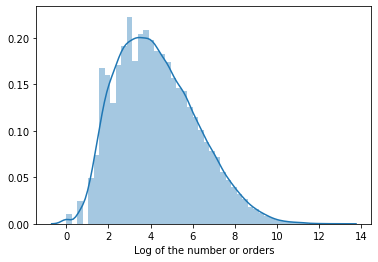

In [16]:
sns.distplot(np.log(products['n_orders'].values))
plt.xlabel('Log of the number or orders')
plt.show()

In [17]:
# lets save prod_95 so we can use it later
prod_95.to_pickle('Data/instacart_2017_05_01/prod_95.pkl')

In [61]:
prod_95=pd.read_pickle('Data/instacart_2017_05_01/prod_95.pkl')

In [62]:
prod_95['product_name']=prod_95['product_name'].apply(lowercase_all)

## Assign a nutrition grade to instacart products

We now want to assign a nutrition grade to the instacart items, similar to the openfoodfacts grade. The way we compute this similarity score is the following. We first add a column for each nutritional grade to prod_95. Then for each word in the product's name, if it is present in the dictionnary of a nutritional grade, we add the number of occurences of that word in the dictionnary. The nutritional grade for a given category is given by the number of occurences of the words of the product's name in the category's dictionnary, divided by the length of the given product's name and the respective dictionnary, to avoid bias.

In [63]:
nutritional_grades=['a','b','c','d','e']

In [64]:
# Compute the nutrion grade
for grade in nutritional_grades:
    tmp=[]
    #check_list=[i[0] for i in translated_dict['a']]
    for name in prod_95['product_name']:
        aux=[]
        for word in name.split():
            if word in grade_dict[grade]:
                 aux.append(grade_dict[grade][word])
        tmp.append(sum(aux)/(len(grade_dict[grade])*len(name.split())))
    prod_95[grade]=tmp
        

In [65]:
def normalize_perline(df,cols=nutritional_grades):
    ''' Function to normalize per row the grades'''
    tmp=sum(df[nutritional_grades])
    if tmp!=0:
        for i in nutritional_grades:
            df[i]=100*df[i]/tmp
    return df

In [66]:
# we also normalize the grades per row
prod_95=prod_95.apply(normalize_perline,axis=1)

In [67]:
prod_95

,product_name,aisle_id,department_id,n_orders,a,b,c,d,e
product_id,,,,,,,,,
24852,banana,24,4,472565,30.809797,13.431133,13.856981,13.670378,28.231712
13176,bag of organic bananas,24,4,379450,35.049515,18.180389,21.178620,15.571935,10.019541
21137,organic strawberries,24,4,264683,34.462101,14.859666,25.014026,17.135504,8.528703
21903,organic baby spinach,123,4,241921,42.491636,16.504358,17.369406,14.696813,8.937786
47209,organic hass avocado,24,4,213584,38.086664,16.822688,18.977637,16.147514,9.965497
...,...,...,...,...,...,...,...,...,...
20590,disinfecting wipes fresh scent,114,17,2288,27.021447,20.450656,20.122514,24.917658,7.487726
2974,regular,77,7,2287,19.014870,21.684603,16.822459,10.771693,31.706374
9422,hummus,67,20,2286,27.600335,29.994289,33.897959,8.507418,0.000000


In [68]:
# add a column for containing the max nutrition score for each product
def max_grade(row):
    tmp = max(row['a'], row['b'], row['c'], row['d'], row['e'])
    for grade in ['a','b','c','d','e']:
        if tmp == row[grade]:
            return grade

In [69]:
tmp = prod_95.apply(lambda row: max_grade(row), axis=1)

In [70]:
tmp

product_id
24852    a
13176    a
21137    a
21903    a
47209    a
        ..
20590    a
2974     e
9422     c
33095    d
37971    c
Length: 2486, dtype: object

In [71]:
prod_95["max_score"]=tmp

In [72]:
prod_95

,product_name,aisle_id,department_id,n_orders,a,b,c,d,e,max_score
product_id,,,,,,,,,,
24852,banana,24,4,472565,30.809797,13.431133,13.856981,13.670378,28.231712,a
13176,bag of organic bananas,24,4,379450,35.049515,18.180389,21.178620,15.571935,10.019541,a
21137,organic strawberries,24,4,264683,34.462101,14.859666,25.014026,17.135504,8.528703,a
21903,organic baby spinach,123,4,241921,42.491636,16.504358,17.369406,14.696813,8.937786,a
47209,organic hass avocado,24,4,213584,38.086664,16.822688,18.977637,16.147514,9.965497,a
...,...,...,...,...,...,...,...,...,...,...
20590,disinfecting wipes fresh scent,114,17,2288,27.021447,20.450656,20.122514,24.917658,7.487726,a
2974,regular,77,7,2287,19.014870,21.684603,16.822459,10.771693,31.706374,e
9422,hummus,67,20,2286,27.600335,29.994289,33.897959,8.507418,0.000000,c


## Add nutrition grade to orders_merged and keep only most orderered products

In [73]:
orders_merged

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0
...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,25247,prior,24,2,6,21.0
32434485,3421083,11352,7,0,25247,prior,24,2,6,21.0
32434486,3421083,4600,8,0,25247,prior,24,2,6,21.0
32434487,3421083,24852,9,1,25247,prior,24,2,6,21.0


In [74]:
# keep only products in prod_95

In [75]:
orders_merged = pd.merge(prod_95, orders_merged, on='product_id')

In [76]:
orders_merged

,product_id,product_name,aisle_id,department_id,n_orders,a,b,c,d,e,max_score,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,24852,banana,24,4,472565,30.809797,13.431133,13.856981,13.670378,28.231712,a,10,1,1,135442,prior,4,6,8,8.0
1,24852,banana,24,4,472565,30.809797,13.431133,13.856981,13.670378,28.231712,a,20,6,0,182912,prior,1,6,17,NaN
2,24852,banana,24,4,472565,30.809797,13.431133,13.856981,13.670378,28.231712,a,22,3,1,30822,prior,25,1,8,12.0
3,24852,banana,24,4,472565,30.809797,13.431133,13.856981,13.670378,28.231712,a,26,2,1,153404,prior,2,0,16,7.0
4,24852,banana,24,4,472565,30.809797,13.431133,13.856981,13.670378,28.231712,a,52,2,1,27498,prior,18,3,10,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22658446,37971,organic cranberry pomegranate juice,98,7,2286,21.393296,20.093737,24.807185,14.399748,19.306033,c,3418643,8,1,72744,prior,15,0,15,4.0
22658447,37971,organic cranberry pomegranate juice,98,7,2286,21.393296,20.093737,24.807185,14.399748,19.306033,c,3418818,14,0,153908,prior,4,3,9,7.0
22658448,37971,organic cranberry pomegranate juice,98,7,2286,21.393296,20.093737,24.807185,14.399748,19.306033,c,3419138,9,1,183235,prior,42,3,13,8.0
22658449,37971,organic cranberry pomegranate juice,98,7,2286,21.393296,20.093737,24.807185,14.399748,19.306033,c,3419483,2,0,75446,prior,18,2,13,3.0


# Drop products that don't interest us
we drop all the poducts in departments pets, personal care, household and babies

In [77]:
dep

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [78]:
orders_merged = orders_merged[(orders_merged.department_id != 8) & (orders_merged.department_id != 11)
                             & (orders_merged.department_id != 17) & (orders_merged.department_id != 18)]

In [79]:
# save for later use
orders_merged.to_pickle('Data/instacart_2017_05_01/orders_merged.pkl')

In [80]:
orders_merged.shape

(22196841, 20)

# load preprocessed data and work with it

In [8]:
orders_merged = pd.read_pickle('Data/instacart_2017_05_01/orders_merged.pkl')

In [17]:
orders_merged

,product_id,product_name,aisle_id,department_id,n_orders,a,b,c,d,e,max_score,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,24852,banana,24,4,472565,30.809797,13.431133,13.856981,13.670378,28.231712,a,10,1,1,135442,prior,4,6,8,8.0
1,24852,banana,24,4,472565,30.809797,13.431133,13.856981,13.670378,28.231712,a,20,6,0,182912,prior,1,6,17,NaN
2,24852,banana,24,4,472565,30.809797,13.431133,13.856981,13.670378,28.231712,a,22,3,1,30822,prior,25,1,8,12.0
3,24852,banana,24,4,472565,30.809797,13.431133,13.856981,13.670378,28.231712,a,26,2,1,153404,prior,2,0,16,7.0
4,24852,banana,24,4,472565,30.809797,13.431133,13.856981,13.670378,28.231712,a,52,2,1,27498,prior,18,3,10,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22658446,37971,organic cranberry pomegranate juice,98,7,2286,21.393296,20.093737,24.807185,14.399748,19.306033,c,3418643,8,1,72744,prior,15,0,15,4.0
22658447,37971,organic cranberry pomegranate juice,98,7,2286,21.393296,20.093737,24.807185,14.399748,19.306033,c,3418818,14,0,153908,prior,4,3,9,7.0
22658448,37971,organic cranberry pomegranate juice,98,7,2286,21.393296,20.093737,24.807185,14.399748,19.306033,c,3419138,9,1,183235,prior,42,3,13,8.0
22658449,37971,organic cranberry pomegranate juice,98,7,2286,21.393296,20.093737,24.807185,14.399748,19.306033,c,3419483,2,0,75446,prior,18,2,13,3.0


In [83]:
# e.g. retrieve products for order id == 10
orders_merged[orders_merged.order_id == 10]

,product_id,product_name,aisle_id,department_id,n_orders,a,b,c,d,e,max_score,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,24852,banana,24,4,472565,30.809797,13.431133,13.856981,13.670378,28.231712,a,10,1,1,135442,prior,4,6,8,8.0
852015,21137,organic strawberries,24,4,264683,34.462101,14.859666,25.014026,17.135504,8.528703,a,10,7,1,135442,prior,4,6,8,8.0
1572203,47766,organic avocado,24,4,176815,37.836389,16.890691,19.054351,16.212788,10.005781,a,10,4,1,135442,prior,4,6,8,8.0
3652016,49235,organic half & half,53,16,76360,36.202685,17.921911,18.751001,17.140061,9.984342,a,10,12,1,135442,prior,4,6,8,8.0
3879427,4605,yellow onions,83,4,73167,31.048117,14.162939,24.199897,25.492021,5.097027,a,10,5,1,135442,prior,4,6,8,8.0
4313903,31717,organic cilantro,16,4,69524,37.876047,17.129902,19.188883,15.908853,9.896313,a,10,3,0,135442,prior,4,6,8,8.0
6806705,27156,organic black beans,59,15,38001,63.621582,11.217369,9.275600,11.082225,4.803224,a,10,10,0,135442,prior,4,6,8,8.0
8036885,14992,green beans,83,4,29069,63.507733,9.560258,8.126552,14.384563,4.420894,a,10,11,0,135442,prior,4,6,8,8.0
12532097,3464,"organic butterhead (boston, butter, bibb) lettuce",83,4,12137,38.176359,16.857595,19.011733,16.000802,9.953511,a,10,14,0,135442,prior,4,6,8,8.0
14484995,1529,"parsley, italian (flat), new england grown",16,4,8736,32.102522,16.735905,18.257854,21.433133,11.470585,a,10,6,0,135442,prior,4,6,8,8.0


# Analysis of the nutrition score of the orders
We define several functions to study the relationships between different attributes of the orders and the nutrition score of the products

In [95]:
nutri_score = ['a', 'b', 'c', 'd', 'e']

## How many different products for each grade ?

Take a look at the products in each grade:

In [108]:
products_df = orders_merged.drop_duplicates(subset ="product_id", 
                     keep = 'first', inplace = False) 

Text(0.5, 0, 'grade')

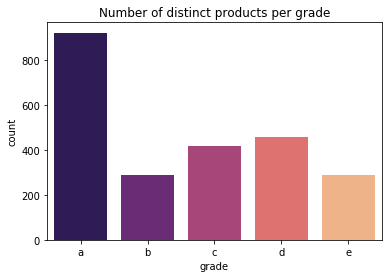

In [100]:
ax = sns.countplot(x = 'max_score', data = products_df, order = nutri_score, palette = 'magma')
ax.set_title('Number of distinct products per grade')
ax.set_xlabel('grade')

In [110]:
products_df[products_df.max_score == 'e']

,product_id,product_name,aisle_id,department_id,n_orders,a,b,c,d,e,max_score,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1749018,47626,large lemon,24,4,152657,25.400949,18.488421,10.511598,16.590975,29.008058,e,28,6,1,98256,prior,29,3,13,6.0
6487895,27344,uncured genoa salami,96,20,41473,0.000000,0.369156,4.295755,14.670089,80.665000,e,41,1,1,85264,prior,20,2,11,21.0
6650001,28199,"clementines, bag",123,4,39825,25.097204,5.724182,17.762801,14.217261,37.198552,e,32,9,1,119216,prior,4,1,19,11.0
6689826,15290,orange bell pepper,83,4,39188,4.415368,10.962088,30.123159,22.716293,31.783092,e,77,10,1,91667,prior,19,1,11,5.0
7102465,196,soda,77,7,35791,4.627651,13.721198,12.282250,7.209147,62.159754,e,13,4,0,45082,prior,2,6,17,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22601037,12033,raspberries dark chocolate bar,45,19,2310,7.834950,6.371928,12.849172,21.963760,50.980190,e,546,9,1,141401,prior,18,2,11,4.0
22607961,16732,peanut milk chocolate xxl bag,45,19,2304,7.139361,25.541814,11.477426,18.156293,37.685106,e,971,4,1,179837,prior,9,4,10,6.0
22612568,7413,chocolate peppermint stick bar,3,19,2302,4.637738,7.228147,12.250409,22.487773,53.395932,e,467,17,0,140348,prior,8,6,10,22.0
22628666,44728,creamy natural peanut butter and flaxseed,88,13,2298,16.549271,12.405739,10.502580,21.663972,38.878439,e,470,8,1,4793,prior,14,5,15,30.0


### Wordcloud representation of products per grade ?

## Overall view of repartition of nutrition grade in ordered products

Text(0.5, 0, 'grade')

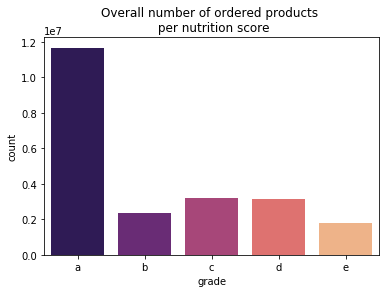

In [102]:
ax = sns.countplot(x = 'max_score', data = orders_merged, order = nutri_score, palette = 'magma')
ax.set_title('Overall number of ordered products \n per nutrition score')
ax.set_xlabel('grade')

## Repartition of nutrition grade within an order
We want to find out the proportion of items with a same grade within the orders. We group our dataframe per order_id and compute the proportion of every grade within each order.

In [10]:
prop_df = orders_merged.groupby(['order_id'])['max_score'].value_counts(normalize = True)

In [11]:
prop_df

order_id  max_score
2         a            0.600000
          d            0.200000
          e            0.200000
3         a            0.857143
          c            0.142857
                         ...   
3421082   c            0.400000
          d            0.400000
          a            0.200000
3421083   a            0.666667
          e            0.333333
Name: max_score, Length: 8889928, dtype: float64

In order to avoid bias, we want to drop the orders containing a single item (indeed, for these orders the proportion of a grade is 100 % )

In [12]:
prop_df_2 = orders_merged.groupby(["order_id", "max_score"]).size().reset_index(name='count')

In [13]:
prop_df_2

,order_id,max_score,count
0,2,a,3
1,2,d,1
2,2,e,1
3,3,a,6
4,3,c,1
...,...,...,...
8889923,3421082,a,1
8889924,3421082,c,2
8889925,3421082,d,2
8889926,3421083,a,2


In [14]:
prop_df_2["proportion"] = prop_df.values

In [15]:
prop_df_2

,order_id,max_score,count,proportion
0,2,a,3,0.600000
1,2,d,1,0.200000
2,2,e,1,0.200000
3,3,a,6,0.857143
4,3,c,1,0.142857
...,...,...,...,...
8889923,3421082,a,1,0.400000
8889924,3421082,c,2,0.400000
8889925,3421082,d,2,0.200000
8889926,3421083,a,2,0.666667


The following lines are here to drop orders containing an unique item

In [16]:
tmp = pd.DataFrame(prop_df_2['order_id'].value_counts())

In [17]:
tmp.rename(columns = {"order_id" : "number"}, inplace = True)

In [18]:
tmp['order_id'] = tmp.index

In [19]:
tmp = tmp[tmp.number != 1]

In [20]:
tmp

,number,order_id
3352985,5,3352985
211857,5,211857
241768,5,241768
626060,5,626060
2293948,5,2293948
...,...,...
2861919,2,2861919
724851,2,724851
1240136,2,1240136
2628377,2,2628377


In [21]:
prop_df_3 = tmp.merge(prop_df_2, on = 'order_id')

In [22]:
prop_df_3.sort_values(by = 'order_id', inplace = True)

In [23]:
prop_df_3.drop(['number'], axis = 1, inplace =True)

In [24]:
# This df now contains the proportion of each grade within each order and single item 
# orders have been dropped
prop_df_3

,order_id,max_score,count,proportion
6454843,2,a,3,0.600000
6454844,2,d,1,0.200000
6454845,2,e,1,0.200000
6906056,3,c,1,0.142857
6906055,3,a,6,0.857143
...,...,...,...,...
6799306,3421082,a,1,0.400000
6799307,3421082,c,2,0.400000
6799308,3421082,d,2,0.200000
7753727,3421083,a,2,0.666667


Text(0.5, 0, 'grade')

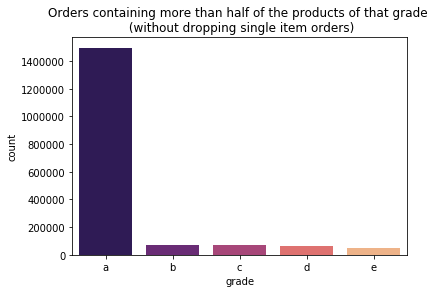

In [258]:
ax = sns.countplot(x = 'max_score',data = prop_df_2[prop_df_2.proportion > 0.5], 
                   order = nutri_score, palette = 'magma')
ax.set_title('Orders containing more than half of the products of that grade \n (without dropping single item orders)')
ax.set_xlabel('grade')

Text(0.5, 0, 'grade')

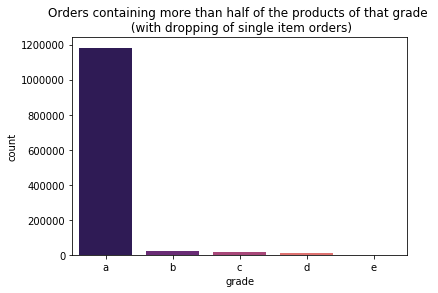

In [261]:
ax = sns.countplot(x = 'max_score',data = prop_df_3[prop_df_3.proportion > 0.5], 
                   order = nutri_score, palette = 'magma')
ax.set_title('Orders containing more than half of the products of that grade \n (with dropping of single item orders)')
ax.set_xlabel('grade')

In [244]:
prop_df_3[(prop_df_3.proportion > 0.5) & (prop_df_3.max_score == 'e')]

,order_id,max_score,count,proportion


--> never order only 'e' products when more than 1 item is ordered

## Composition of the orders: Distribution of number of products of each grade in the orders

In [57]:
# work with prop_df_3
prop_df_3

,order_id,max_score,count,proportion
6454843,2,a,3,0.600000
6454844,2,d,1,0.200000
6454845,2,e,1,0.200000
6906056,3,c,1,0.142857
6906055,3,a,6,0.857143
...,...,...,...,...
6799306,3421082,a,1,0.400000
6799307,3421082,c,2,0.400000
6799308,3421082,d,2,0.200000
7753727,3421083,a,2,0.666667


For each order, we want to add the missing grades with proportion 0%.

In [25]:
# get the orders :
distinct_orders = prop_df_3.order_id.drop_duplicates(keep = 'first', inplace = False)

In [97]:
# create new df prop_df_4 containing for each order also the grades with proportion 0
# takes a long time to run
prop_df_4 = prop_df_3.copy()
for grade in nutri_score:
    tmp =pd.DataFrame([distinct_orders.values, [grade]*len(distinct_orders), np.zeros(len(distinct_orders)),
                                                                           np.zeros(len(distinct_orders))]).T
    tmp.columns = ['order_id', 'max_score', 'count', 'proportion']
    prop_df_4 = pd.merge(tmp,prop_df_4, on = ["order_id", "max_score"], how = 'outer')
    prop_df_4.sort_values(by=['order_id'], inplace = True)
    #prop_df_4.drop(columns = ["count_x", "proportion_x"], inplace = True)
    prop_df_4.fillna(0, inplace = True)
    

In [144]:
prop_df_4.drop(["count_x", "proportion_x"], axis= 1,inplace = True)
prop_df_4.columns = ["order_id", "max_score", "drop", "drop", "drop", 
                     "drop", "count", "proportion"]
prop_df_4.drop("drop", axis = 1, inplace = True)

In [147]:
# save for later use
prop_df_4.to_pickle('Data/instacart_2017_05_01/prop_df_4.pkl')

In [148]:
prop_df_4.head(10) # now contains also grades for which proportion is 0

,order_id,max_score,count,proportion
0,2.0,e,1.0,0.200000
2570683,2.0,d,1.0,0.200000
2570684,2.0,a,3.0,0.600000
2570685,2.0,b,0.0,0.000000
2570686,2.0,c,0.0,0.000000
1,3.0,e,0.0,0.000000
2570690,3.0,a,6.0,0.857143
2570689,3.0,b,0.0,0.000000
2570687,3.0,d,0.0,0.000000
2570688,3.0,c,1.0,0.142857


## Distribtion of grades in orders

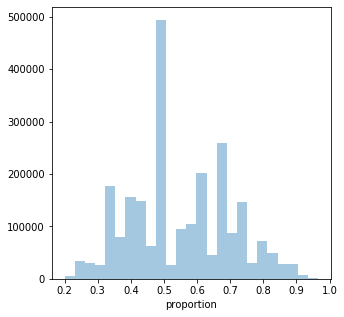

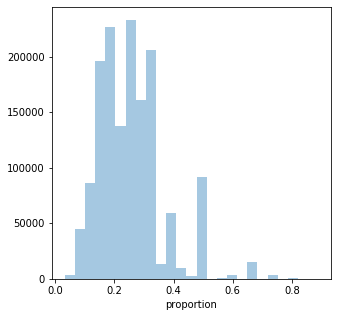

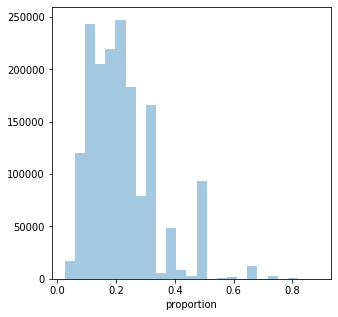

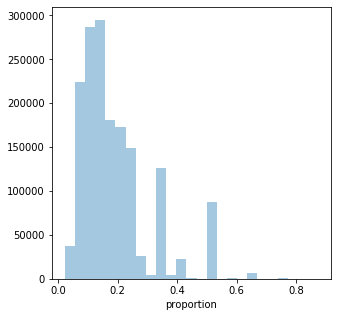

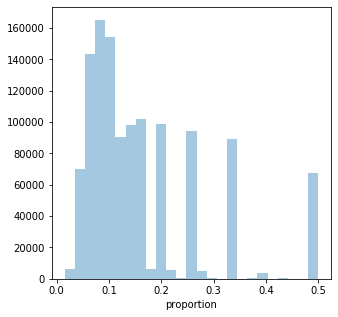

In [194]:
# plots with prop_df_3, i.e. without counting the orders containing 0 % of that grade
for grade in nutri_score:
    tmp = prop_df_3[prop_df_3.max_score == grade]
    fig, ax=plt.subplots(figsize=(5,5))
    sns.distplot(tmp.proportion, kde = False, ax=ax, bins = 25)
    # plt.ylim(0, None)
    # plt.xlim(0, 1)

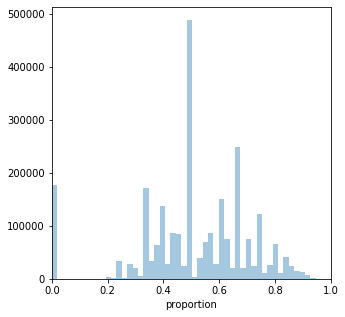

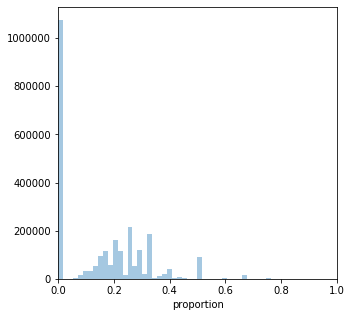

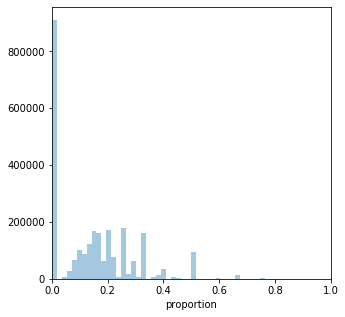

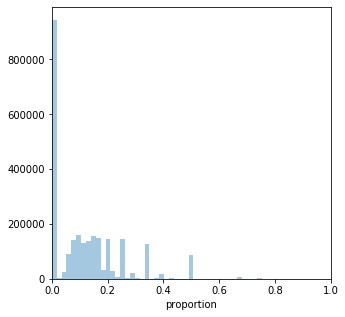

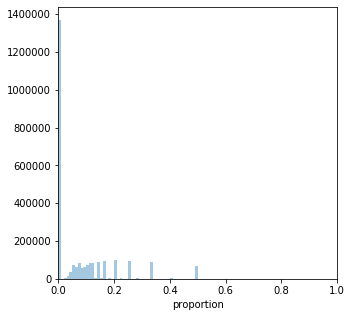

In [187]:
# plots with prop_df_4, i.e. also counting the orders containing 0 % of that grade
for grade in nutri_score:
    tmp = prop_df_4[prop_df_4.max_score == grade]
    fig, ax=plt.subplots(figsize=(5,5))
    sns.distplot(tmp.proportion, kde = False, ax=ax)
    plt.ylim(0, None)
    plt.xlim(0, 1)

    plt.title("")
    plt.show()